# 🚀 Post-Experiment Analysis: Multi-Agent LLM Optimization

This notebook provides comprehensive analysis of multi-agent LLM optimization experiments, including evolution tracking and Pareto front visualization.

## 📊 **Analysis Features:**
- **📁 Automatic Detection**: Finds the latest experiment run automatically
- **📈 Evolution Tracking**: Plots best performance/cost over iterations
- **🎯 3D Pareto Analysis**: Interactive 3D evolution of Pareto fronts
- **💾 Auto-Save**: Saves all visualizations to experiment output folder

## ⚙️ **Setup Requirements:**
- Run this notebook from the LLM Multi-Agent Optimization Framework directory
- Ensure experiment outputs exist in the `outputs/` folder
- Required libraries: matplotlib, plotly, pandas, numpy

---

In [26]:
# 📦 Install Required Packages
!pip install plotly pandas matplotlib numpy seaborn

In [27]:
# Import Required Libraries
import os
import json
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
from datetime import datetime
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set style for better plots
plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 10

print("📦 All required libraries imported successfully!")
print("📍 Current working directory:", os.getcwd())

📦 All required libraries imported successfully!
📍 Current working directory: /teamspace/studios/this_studio/LLM Multi-Agent Optimization Framework


In [28]:
# 📁 Find Latest Experiment Run
def find_latest_experiment():
    """Find the most recent experiment run based on the latest checkpoint file timestamps."""
    # Use absolute path to ensure we find the correct outputs directory
    base_dir = "/teamspace/studios/this_studio/LLM Multi-Agent Optimization Framework"
    outputs_dir = os.path.join(base_dir, "outputs")
    
    if not os.path.exists(outputs_dir):
        print(f"❌ Outputs directory '{outputs_dir}' not found!")
        return None
    
    # Get all experiment folders
    experiment_folders = [
        d for d in os.listdir(outputs_dir) 
        if os.path.isdir(os.path.join(outputs_dir, d)) and d != ".gitkeep"
    ]
    
    if not experiment_folders:
        print(f"❌ No experiment folders found in '{outputs_dir}'!")
        return None
    
    # Find the experiment with the most recent checkpoint file
    latest_experiment = None
    latest_checkpoint_time = 0
    
    print(f"🔍 Checking {len(experiment_folders)} experiment folders for recent checkpoints...")
    
    for folder in experiment_folders:
        folder_path = os.path.join(outputs_dir, folder)
        
        # Find checkpoint files in this folder
        checkpoint_files = glob.glob(os.path.join(folder_path, "checkpoint_iter_*.json"))
        
        if checkpoint_files:
            # Get the most recent checkpoint file in this folder
            most_recent_checkpoint = max(checkpoint_files, key=os.path.getmtime)
            checkpoint_time = os.path.getmtime(most_recent_checkpoint)
            
            if checkpoint_time > latest_checkpoint_time:
                latest_checkpoint_time = checkpoint_time
                latest_experiment = folder_path
    
    if latest_experiment:
        experiment_name = os.path.basename(latest_experiment)
        latest_checkpoint_date = datetime.fromtimestamp(latest_checkpoint_time)
        
        print(f"📁 Latest experiment: {experiment_name}")
        print(f"📅 Most recent checkpoint: {latest_checkpoint_date}")
        
        # Check for checkpoint files
        checkpoint_files = glob.glob(os.path.join(latest_experiment, "checkpoint_iter_*.json"))
        print(f"📋 Found {len(checkpoint_files)} checkpoint files")
        
        return latest_experiment
    else:
        print(f"❌ No experiments with checkpoint files found in '{outputs_dir}'!")
        return None

# Find the latest experiment
latest_experiment = find_latest_experiment()

if latest_experiment:
    print(f"\n✅ Using experiment folder: {latest_experiment}")
    
    # Check for checkpoint files
    checkpoint_files = glob.glob(os.path.join(latest_experiment, "checkpoint_iter_*.json"))
    print(f"📋 Found {len(checkpoint_files)} checkpoint files")
else:
    print("❌ No experiment found. Please run an optimization first.")

🔍 Checking 71 experiment folders for recent checkpoints...
📁 Latest experiment: jul_29_15_21_botorch_multi_objective_llm_gaia_smolagents
📅 Most recent checkpoint: 2025-07-29 16:51:47.127598
📋 Found 4 checkpoint files

✅ Using experiment folder: /teamspace/studios/this_studio/LLM Multi-Agent Optimization Framework/outputs/jul_29_15_21_botorch_multi_objective_llm_gaia_smolagents
📋 Found 4 checkpoint files


In [29]:
# 📊 Load Checkpoint Data
def load_checkpoint_data(experiment_folder):
    """Load all checkpoint data from experiment iterations."""
    if not experiment_folder:
        return None
    
    checkpoint_files = glob.glob(os.path.join(experiment_folder, "checkpoint_iter_*.json"))
    checkpoint_files.sort()  # Sort by filename for correct iteration order
    
    if not checkpoint_files:
        print(f"❌ No checkpoint files found in {experiment_folder}")
        return None
    
    print(f"📋 Loading {len(checkpoint_files)} checkpoint files...")
    
    checkpoints = []
    for i, checkpoint_file in enumerate(checkpoint_files):
        try:
            with open(checkpoint_file, 'r') as f:
                data = json.load(f)
            
            # Extract key information - handle different formats
            iteration = data.get('iteration', i)
            
            # Try different field names for Y data
            if 'Y_train' in data:
                Y_train = np.array(data['Y_train'])
            elif 'train_y' in data:
                Y_train = np.array(data['train_y'])
            elif 'y' in data:
                Y_train = np.array(data['y'])
            else:
                print(f"⚠️  No Y data found in {checkpoint_file}")
                continue
            
            # Try different field names for X data
            if 'X_train' in data:
                X_train = np.array(data['X_train'])
            elif 'train_x' in data:
                X_train = np.array(data['train_x'])
            elif 'x' in data:
                X_train = np.array(data['x'])
            else:
                print(f"⚠️  No X data found in {checkpoint_file}")
                X_train = np.zeros((len(Y_train), 1))  # Dummy X data
            
            # Convert cost back from negative (BoTorch uses negative for maximization)
            performance = Y_train[:, 0]  # First objective: performance
            cost = -Y_train[:, 1]        # Second objective: cost (convert from negative)
            
            # Filter out zero-cost observations
            non_zero_cost_mask = cost > 0
            zero_cost_count = np.sum(cost == 0)
            
            if zero_cost_count > 0:
                print(f"⚠️  Warning: Found {zero_cost_count} observations with zero cost in iteration {iteration}")
                print(f"    Filtering out zero-cost observations for meaningful analysis...")
                
                if np.sum(non_zero_cost_mask) == 0:
                    print(f"⚠️  All observations have zero cost in iteration {iteration} - skipping this iteration")
                    continue
                
                # Filter data to keep only non-zero cost observations
                performance = performance[non_zero_cost_mask]
                cost = cost[non_zero_cost_mask]
                X_train = X_train[non_zero_cost_mask] if len(X_train) > 0 else X_train
                Y_train_filtered = Y_train[non_zero_cost_mask]
                
                print(f"    Kept {len(performance)} out of {len(Y_train)} observations after filtering")
            else:
                Y_train_filtered = Y_train
            
            checkpoint_info = {
                'iteration': iteration,
                'timestamp': data.get('timestamp', ''),
                'performance': performance,
                'cost': cost,
                'n_evaluations': len(performance),  # Use filtered length
                'best_performance': performance.max(),
                'best_cost': cost.min(),
                'X_train': X_train,
                'Y_train': Y_train_filtered,
                'original_n_evaluations': len(Y_train),  # Keep track of original count
                'zero_cost_filtered': zero_cost_count
            }
            
            checkpoints.append(checkpoint_info)
            
        except Exception as e:
            print(f"⚠️  Failed to load {checkpoint_file}: {e}")
            continue
    
    print(f"✅ Successfully loaded {len(checkpoints)} checkpoints")
    return checkpoints

# Load all checkpoint data
checkpoints = load_checkpoint_data(latest_experiment)

if checkpoints:
    print(f"\n📈 Experiment Summary:")
    print(f"  • Total iterations: {len(checkpoints)}")
    print(f"  • Total evaluations (after filtering): {checkpoints[-1]['n_evaluations']}")
    print(f"  • Best performance achieved: {max(cp['best_performance'] for cp in checkpoints):.3f}")
    print(f"  • Best cost achieved: {min(cp['best_cost'] for cp in checkpoints):.3f}")
    
    # Show filtering statistics
    total_original = sum(cp['original_n_evaluations'] for cp in checkpoints)
    total_filtered = sum(cp['n_evaluations'] for cp in checkpoints)
    total_zero_cost = sum(cp['zero_cost_filtered'] for cp in checkpoints)
    
    if total_zero_cost > 0:
        print(f"\n🚨 Filtering Summary:")
        print(f"  • Original total evaluations: {total_original}")
        print(f"  • Zero-cost observations filtered: {total_zero_cost}")
        print(f"  • Remaining evaluations: {total_filtered}")
        print(f"  • Filtering rate: {total_zero_cost/total_original*100:.1f}%")
    
    # Display progression
    print(f"\n📊 Iteration Progress:")
    for i, cp in enumerate(checkpoints[:5]):  # Show first 5
        filtered_note = f" (filtered {cp['zero_cost_filtered']})" if cp['zero_cost_filtered'] > 0 else ""
        print(f"  Iter {cp['iteration']:2d}: {cp['n_evaluations']:3d} evals{filtered_note}, "
              f"Best Perf: {cp['best_performance']:.3f}, Best Cost: {cp['best_cost']:.3f}")
    if len(checkpoints) > 5:
        print(f"  ... ({len(checkpoints)-5} more iterations)")
else:
    print("❌ No checkpoint data loaded.")

📋 Loading 4 checkpoint files...
⚠️  Warning: Found 1 observations with zero cost in iteration 0
    Filtering out zero-cost observations for meaningful analysis...
    Kept 1 out of 2 observations after filtering
⚠️  Warning: Found 1 observations with zero cost in iteration 1
    Filtering out zero-cost observations for meaningful analysis...
    Kept 2 out of 3 observations after filtering
⚠️  Warning: Found 1 observations with zero cost in iteration 2
    Filtering out zero-cost observations for meaningful analysis...
    Kept 3 out of 4 observations after filtering
⚠️  Warning: Found 1 observations with zero cost in iteration 3
    Filtering out zero-cost observations for meaningful analysis...
    Kept 4 out of 5 observations after filtering
✅ Successfully loaded 4 checkpoints

📈 Experiment Summary:
  • Total iterations: 4
  • Total evaluations (after filtering): 4
  • Best performance achieved: 1.000
  • Best cost achieved: 0.112

🚨 Filtering Summary:
  • Original total evaluation

In [30]:
# 📈 Extract Best Performance and Cost Per Iteration
def extract_evolution_data(checkpoints):
    """Extract best performance and cost evolution over iterations."""
    if not checkpoints:
        return None
    
    evolution_data = {
        'iterations': [],
        'best_performance_cumulative': [],
        'best_cost_cumulative': [],
        'best_performance_per_iter': [],
        'best_cost_per_iter': [],
        'n_evaluations': []
    }
    
    global_best_performance = -np.inf
    global_best_cost = np.inf
    
    for cp in checkpoints:
        iteration = cp['iteration']
        curr_best_perf = cp['best_performance']
        curr_best_cost = cp['best_cost']
        
        # Update global bests (cumulative)
        global_best_performance = max(global_best_performance, curr_best_perf)
        global_best_cost = min(global_best_cost, curr_best_cost)
        
        # Store data
        evolution_data['iterations'].append(iteration)
        evolution_data['best_performance_cumulative'].append(global_best_performance)
        evolution_data['best_cost_cumulative'].append(global_best_cost)
        evolution_data['best_performance_per_iter'].append(curr_best_perf)
        evolution_data['best_cost_per_iter'].append(curr_best_cost)
        evolution_data['n_evaluations'].append(cp['n_evaluations'])
    
    return evolution_data

# Extract evolution data
evolution_data = extract_evolution_data(checkpoints)

if evolution_data:
    print("📈 Evolution Data Summary:")
    print(f"  • Iterations tracked: {len(evolution_data['iterations'])}")
    print(f"  • Initial best performance: {evolution_data['best_performance_cumulative'][0]:.3f}")
    print(f"  • Final best performance: {evolution_data['best_performance_cumulative'][-1]:.3f}")
    print(f"  • Performance improvement: {evolution_data['best_performance_cumulative'][-1] - evolution_data['best_performance_cumulative'][0]:.3f}")
    print(f"  • Initial best cost: {evolution_data['best_cost_cumulative'][0]:.3f}")
    print(f"  • Final best cost: {evolution_data['best_cost_cumulative'][-1]:.3f}")
    print(f"  • Cost improvement: {evolution_data['best_cost_cumulative'][0] - evolution_data['best_cost_cumulative'][-1]:.3f}")
    
    # Create DataFrame for easier manipulation
    evolution_df = pd.DataFrame(evolution_data)
    print(f"\n📊 Evolution DataFrame shape: {evolution_df.shape}")
    print(evolution_df.head())
else:
    print("❌ No evolution data extracted.")

📈 Evolution Data Summary:
  • Iterations tracked: 4
  • Initial best performance: 0.667
  • Final best performance: 1.000
  • Performance improvement: 0.333
  • Initial best cost: 0.204
  • Final best cost: 0.112
  • Cost improvement: 0.092

📊 Evolution DataFrame shape: (4, 6)
   iterations  best_performance_cumulative  best_cost_cumulative  \
0           0                     0.666667              0.204006   
1           1                     0.666667              0.204006   
2           2                     1.000000              0.111717   
3           3                     1.000000              0.111717   

   best_performance_per_iter  best_cost_per_iter  n_evaluations  
0                   0.666667            0.204006              1  
1                   0.666667            0.204006              2  
2                   1.000000            0.111717              3  
3                   1.000000            0.111717              4  


📊 Creating evolution plots...


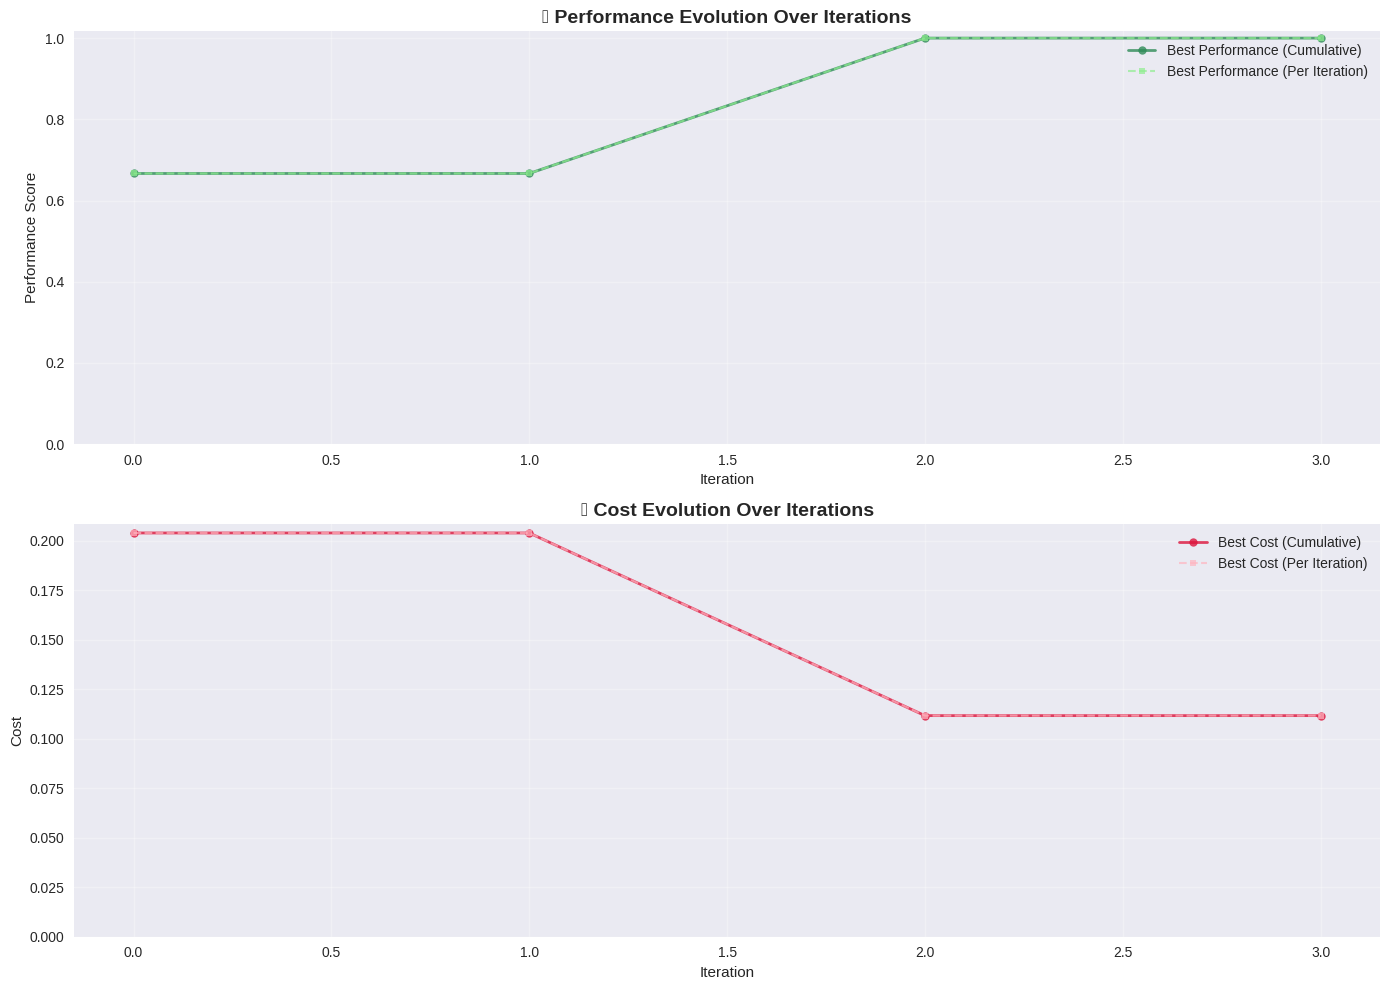


📈 Performance Statistics:
  • Performance improvement: 0.333
  • Cost improvement: 0.092
  • Final performance: 1.000
  • Final cost: 0.112


In [31]:
# 📊 Plot Single Objective Evolution
def plot_evolution(evolution_data, save_path=None):
    """Plot the evolution of best performance and cost over iterations."""
    if not evolution_data:
        print("❌ No evolution data to plot.")
        return None
    
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(14, 10))
    
    iterations = evolution_data['iterations']
    
    # Plot 1: Performance Evolution
    ax1.plot(iterations, evolution_data['best_performance_cumulative'], 
             'o-', color='#2E8B57', linewidth=2, markersize=6, 
             label='Best Performance (Cumulative)', alpha=0.8)
    ax1.plot(iterations, evolution_data['best_performance_per_iter'], 
             's--', color='#90EE90', linewidth=1.5, markersize=4, 
             label='Best Performance (Per Iteration)', alpha=0.7)
    
    ax1.set_xlabel('Iteration')
    ax1.set_ylabel('Performance Score')
    ax1.set_title('🏆 Performance Evolution Over Iterations', fontsize=14, fontweight='bold')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.set_ylim(bottom=0)
    
    # Plot 2: Cost Evolution  
    ax2.plot(iterations, evolution_data['best_cost_cumulative'], 
             'o-', color='#DC143C', linewidth=2, markersize=6, 
             label='Best Cost (Cumulative)', alpha=0.8)
    ax2.plot(iterations, evolution_data['best_cost_per_iter'], 
             's--', color='#FFB6C1', linewidth=1.5, markersize=4, 
             label='Best Cost (Per Iteration)', alpha=0.7)
    
    ax2.set_xlabel('Iteration')
    ax2.set_ylabel('Cost')
    ax2.set_title('💰 Cost Evolution Over Iterations', fontsize=14, fontweight='bold')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_ylim(bottom=0)
    
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"💾 Evolution plot saved to: {save_path}")
    
    plt.show()
    return fig

# Create the evolution plot
if evolution_data:
    print("📊 Creating evolution plots...")
    evolution_fig = plot_evolution(evolution_data)
    
    # Show some statistics
    print(f"\n📈 Performance Statistics:")
    perf_improvement = evolution_data['best_performance_cumulative'][-1] - evolution_data['best_performance_cumulative'][0]
    cost_improvement = evolution_data['best_cost_cumulative'][0] - evolution_data['best_cost_cumulative'][-1]
    
    print(f"  • Performance improvement: {perf_improvement:.3f}")
    print(f"  • Cost improvement: {cost_improvement:.3f}")
    print(f"  • Final performance: {evolution_data['best_performance_cumulative'][-1]:.3f}")
    print(f"  • Final cost: {evolution_data['best_cost_cumulative'][-1]:.3f}")
else:
    print("❌ Cannot create evolution plots - no data available.")

In [32]:
# 🎯 Plot Pareto Front Evolution in 3D
def compute_pareto_front(performance, cost):
    """Compute Pareto front from performance and cost arrays."""
    if len(performance) == 0:
        return np.array([]), np.array([])
    
    # Combine objectives for Pareto calculation
    objectives = np.column_stack([performance, -cost])  # Maximize perf, minimize cost
    n_points = len(objectives)
    is_pareto = np.ones(n_points, dtype=bool)
    
    for i in range(n_points):
        if is_pareto[i]:
            # Check if point i is dominated by any other point
            dominated = np.all(objectives[i] <= objectives, axis=1) & np.any(objectives[i] < objectives, axis=1)
            is_pareto[dominated] = False
    
    return performance[is_pareto], cost[is_pareto]

def plot_3d_pareto_evolution(checkpoints, save_path=None):
    """Create 3D plot showing Pareto front evolution over iterations."""
    if not checkpoints:
        print("❌ No checkpoint data for 3D plot.")
        return None
    
    fig = go.Figure()
    
    # Color palette for iterations
    colors = px.colors.sequential.Viridis
    n_iters = len(checkpoints)
    
    all_performance = []
    all_cost = []
    all_iterations = []
    pareto_performance = []
    pareto_cost = []
    pareto_iterations = []
    
    print(f"📊 Processing {n_iters} iterations for 3D plot...")
    
    for i, cp in enumerate(checkpoints):
        iteration = cp['iteration']
        performance = cp['performance'] 
        cost = cp['cost']
        
        # Store all points
        all_performance.extend(performance)
        all_cost.extend(cost)
        all_iterations.extend([iteration] * len(performance))
        
        # Compute Pareto front for this iteration
        pareto_perf, pareto_cost_vals = compute_pareto_front(performance, cost)
        
        if len(pareto_perf) > 0:
            pareto_performance.extend(pareto_perf)
            pareto_cost.extend(pareto_cost_vals)
            pareto_iterations.extend([iteration] * len(pareto_perf))
            
            # Add Pareto front for this iteration
            color_idx = int(i / n_iters * (len(colors) - 1))
            
            fig.add_trace(go.Scatter3d(
                x=pareto_cost_vals,
                y=pareto_perf,
                z=[iteration] * len(pareto_perf),
                mode='markers+lines',
                marker=dict(
                    size=8,
                    color=colors[color_idx],
                    opacity=0.8,
                    line=dict(width=1, color='black')
                ),
                line=dict(color=colors[color_idx], width=3),
                name=f'Iter {iteration}',
                hovertemplate=f'<b>Iteration {iteration}</b><br>' +
                             'Cost: %{x:.3f}<br>' +
                             'Performance: %{y:.3f}<br>' +
                             '<extra></extra>'
            ))
    
    # Add all evaluated points as semi-transparent background
    fig.add_trace(go.Scatter3d(
        x=all_cost,
        y=all_performance,
        z=all_iterations,
        mode='markers',
        marker=dict(
            size=3,
            color='lightgray',
            opacity=0.2
        ),
        name='All Evaluations',
        showlegend=False,
        hovertemplate='Cost: %{x:.3f}<br>' +
                     'Performance: %{y:.3f}<br>' +
                     'Iteration: %{z}<br>' +
                     '<extra></extra>'
    ))
    
    # Update layout
    fig.update_layout(
        title={
            'text': '🎯 3D Pareto Front Evolution: Cost vs Performance vs Iteration',
            'x': 0.5,
            'font': {'size': 16}
        },
        scene=dict(
            xaxis_title='Cost',
            yaxis_title='Performance',
            zaxis_title='Iteration',
            camera=dict(
                eye=dict(x=1.5, y=1.5, z=1.5)
            )
        ),
        width=900,
        height=700,
        margin=dict(l=0, r=0, b=0, t=50)
    )
    
    if save_path:
        fig.write_html(save_path)
        print(f"💾 3D Pareto plot saved to: {save_path}")
    
    fig.show()
    return fig

# Create 3D Pareto evolution plot
if checkpoints:
    print("🎯 Creating 3D Pareto front evolution plot...")
    pareto_3d_fig = plot_3d_pareto_evolution(checkpoints)
    
    # Summary statistics
    print(f"\n📊 3D Plot Statistics:")
    total_evaluations = sum(cp['n_evaluations'] for cp in checkpoints)
    print(f"  • Total points plotted: {total_evaluations}")
    print(f"  • Iterations shown: {len(checkpoints)}")
    
    # Calculate final Pareto front size
    final_cp = checkpoints[-1]
    final_pareto_perf, final_pareto_cost = compute_pareto_front(
        final_cp['performance'], final_cp['cost']
    )
    print(f"  • Final Pareto front size: {len(final_pareto_perf)} solutions")
else:
    print("❌ Cannot create 3D plot - no checkpoint data available.")

🎯 Creating 3D Pareto front evolution plot...
📊 Processing 4 iterations for 3D plot...



📊 3D Plot Statistics:
  • Total points plotted: 10
  • Iterations shown: 4
  • Final Pareto front size: 2 solutions


💾 Starting visualization export...
📁 Created visualization folder: /teamspace/studios/this_studio/LLM Multi-Agent Optimization Framework/outputs/jul_29_15_21_botorch_multi_objective_llm_gaia_smolagents/visualizations
💾 Saving all visualizations...
💾 Evolution plot saved to: /teamspace/studios/this_studio/LLM Multi-Agent Optimization Framework/outputs/jul_29_15_21_botorch_multi_objective_llm_gaia_smolagents/visualizations/evolution_plot.png


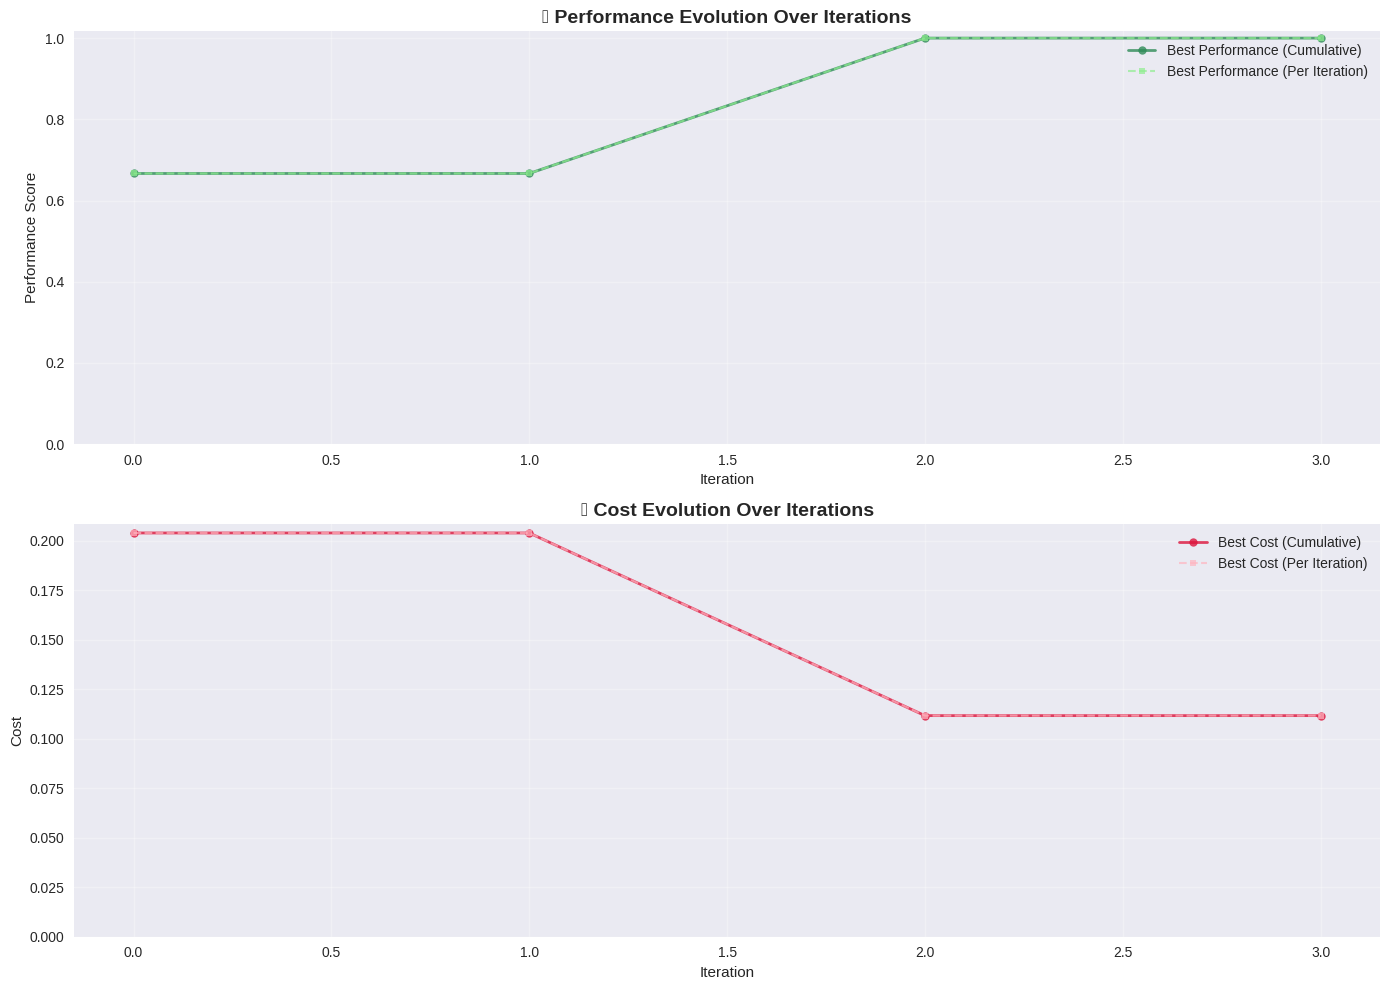

📊 Processing 4 iterations for 3D plot...
💾 3D Pareto plot saved to: /teamspace/studios/this_studio/LLM Multi-Agent Optimization Framework/outputs/jul_29_15_21_botorch_multi_objective_llm_gaia_smolagents/visualizations/pareto_3d_evolution.html


📄 Analysis summary saved to: /teamspace/studios/this_studio/LLM Multi-Agent Optimization Framework/outputs/jul_29_15_21_botorch_multi_objective_llm_gaia_smolagents/visualizations/analysis_summary.txt

✅ Visualization complete! Saved 3 files:
  📄 analysis_summary.txt (0.8 KB)
  📄 evolution_plot.png (293.2 KB)
  📄 pareto_3d_evolution.html (4554.9 KB)

📁 All visualizations saved to: /teamspace/studios/this_studio/LLM Multi-Agent Optimization Framework/outputs/jul_29_15_21_botorch_multi_objective_llm_gaia_smolagents/visualizations

🎉 SUCCESS! All visualizations saved to:
   /teamspace/studios/this_studio/LLM Multi-Agent Optimization Framework/outputs/jul_29_15_21_botorch_multi_objective_llm_gaia_smolagents/visualizations

📋 To view the results:
   • Open evolution_plot.png for iteration tracking
   • Open pareto_3d_evolution.html in a browser for interactive 3D plot
   • Read analysis_summary.txt for detailed statistics


In [33]:
# 💾 Save Visualizations to Output Folder
def create_visualization_folder(experiment_folder):
    """Create visualization folder within experiment output."""
    if not experiment_folder:
        return None
    
    viz_folder = os.path.join(experiment_folder, "visualizations")
    os.makedirs(viz_folder, exist_ok=True)
    print(f"📁 Created visualization folder: {viz_folder}")
    return viz_folder

def save_all_visualizations(experiment_folder, evolution_data, checkpoints):
    """Save all generated plots to the visualization folder."""
    if not experiment_folder:
        print("❌ No experiment folder specified.")
        return
    
    viz_folder = create_visualization_folder(experiment_folder)
    
    if not viz_folder:
        print("❌ Could not create visualization folder.")
        return
    
    print("💾 Saving all visualizations...")
    
    # 1. Save evolution plot
    if evolution_data:
        evolution_path = os.path.join(viz_folder, "evolution_plot.png")
        evolution_fig = plot_evolution(evolution_data, save_path=evolution_path)
        plt.close(evolution_fig)  # Close to free memory
    
    # 2. Save 3D Pareto plot 
    if checkpoints:
        pareto_3d_path = os.path.join(viz_folder, "pareto_3d_evolution.html")
        pareto_3d_fig = plot_3d_pareto_evolution(checkpoints, save_path=pareto_3d_path)
    
    # 3. Save summary statistics
    summary_path = os.path.join(viz_folder, "analysis_summary.txt")
    with open(summary_path, 'w') as f:
        f.write("🚀 Multi-Agent LLM Optimization - Post-Experiment Analysis Summary\n")
        f.write("="*70 + "\n\n")
        
        if evolution_data:
            f.write("📈 EVOLUTION STATISTICS:\n")
            f.write(f"  • Total iterations: {len(evolution_data['iterations'])}\n")
            f.write(f"  • Initial best performance: {evolution_data['best_performance_cumulative'][0]:.3f}\n")
            f.write(f"  • Final best performance: {evolution_data['best_performance_cumulative'][-1]:.3f}\n")
            f.write(f"  • Performance improvement: {evolution_data['best_performance_cumulative'][-1] - evolution_data['best_performance_cumulative'][0]:.3f}\n")
            f.write(f"  • Initial best cost: {evolution_data['best_cost_cumulative'][0]:.3f}\n")
            f.write(f"  • Final best cost: {evolution_data['best_cost_cumulative'][-1]:.3f}\n")
            f.write(f"  • Cost improvement: {evolution_data['best_cost_cumulative'][0] - evolution_data['best_cost_cumulative'][-1]:.3f}\n\n")
        
        if checkpoints:
            f.write("📊 CHECKPOINT STATISTICS:\n")
            total_evals = checkpoints[-1]['n_evaluations']
            f.write(f"  • Total evaluations: {total_evals}\n")
            f.write(f"  • Iterations completed: {len(checkpoints)}\n")
            f.write(f"  • Average evaluations per iteration: {total_evals/len(checkpoints):.1f}\n")
            
            # Final Pareto front
            final_cp = checkpoints[-1]
            final_pareto_perf, final_pareto_cost = compute_pareto_front(
                final_cp['performance'], final_cp['cost']
            )
            f.write(f"  • Final Pareto front size: {len(final_pareto_perf)} solutions\n")
            f.write(f"  • Pareto efficiency: {len(final_pareto_perf)/total_evals*100:.1f}%\n\n")
        
        f.write("📁 GENERATED FILES:\n")
        f.write("  • evolution_plot.png - Performance and cost evolution over iterations\n")
        f.write("  • pareto_3d_evolution.html - Interactive 3D Pareto front evolution\n")
        f.write("  • analysis_summary.txt - This summary file\n")
        
        f.write(f"\n📅 Analysis generated on: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
    
    print(f"📄 Analysis summary saved to: {summary_path}")
    
    # 4. List all saved files
    saved_files = [f for f in os.listdir(viz_folder) if os.path.isfile(os.path.join(viz_folder, f))]
    
    print(f"\n✅ Visualization complete! Saved {len(saved_files)} files:")
    for file in sorted(saved_files):
        file_path = os.path.join(viz_folder, file)
        file_size = os.path.getsize(file_path) / 1024  # KB
        print(f"  📄 {file} ({file_size:.1f} KB)")
    
    print(f"\n📁 All visualizations saved to: {viz_folder}")
    return viz_folder

# Save all visualizations
if latest_experiment and (evolution_data or checkpoints):
    print("💾 Starting visualization export...")
    saved_viz_folder = save_all_visualizations(latest_experiment, evolution_data, checkpoints)
    
    if saved_viz_folder:
        print(f"\n🎉 SUCCESS! All visualizations saved to:")
        print(f"   {saved_viz_folder}")
        print(f"\n📋 To view the results:")
        print(f"   • Open evolution_plot.png for iteration tracking")
        print(f"   • Open pareto_3d_evolution.html in a browser for interactive 3D plot")
        print(f"   • Read analysis_summary.txt for detailed statistics")
else:
    print("❌ Cannot save visualizations - no experiment data available.")

## 🎉 Analysis Complete!

### 📊 **What We've Generated:**

1. **📈 Evolution Tracking**: Line plots showing how the best performance and cost evolved over optimization iterations
2. **🎯 3D Pareto Visualization**: Interactive 3D plot showing how the Pareto front evolved across iterations
3. **💾 Saved Outputs**: All plots and analysis summaries saved to the experiment's `visualizations/` folder

### 🔍 **Key Insights:**

- **Performance Improvement**: Track how the optimization algorithm improved solutions over time
- **Cost Efficiency**: See how cost-effective solutions were discovered
- **Pareto Evolution**: Understand how the trade-off frontier between performance and cost evolved
- **Convergence Behavior**: Analyze whether the optimization converged or could benefit from more iterations

### 📋 **Next Steps:**

1. **Review the 3D Plot**: Open the HTML file in a browser for interactive exploration
2. **Analyze Trade-offs**: Use the evolution plots to understand optimization dynamics
3. **Parameter Tuning**: If convergence seems poor, consider adjusting optimization parameters
4. **Architecture Comparison**: Run multiple experiments with different architectures and compare results

### 🔧 **Rerunning Analysis:**

To analyze a different experiment, simply:
1. Update the `latest_experiment` variable to point to a different folder
2. Re-run the notebook cells
3. All visualizations will be regenerated and saved

---

**Happy optimizing! 🚀**